## Thermohaline variability

In [3]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as scipy
import cmocean
import math
import gsw
import imp 
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

plt.rcParams['font.size'] = '13'

In [4]:
workingdir = r'C:\Users\mijakes\checkouts\phd-public'
os.chdir(workingdir) 

import src.importData as imports
import src.calc as calc
import src.interpolation as interp
import src.plots as plots
import src.stats as stats
import src.concat as ct
import src.velocities as vel
import src.settings as settings

In [5]:
# Import satellite altimetry data 
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data')
alt_cmems = imports.importNetCDF(datadir, 'CMEMS.nc', datatype ='altimetry')

In [6]:
# Path to save figures
my_path = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd','figures', 'chapter2_manuscript')

### EM-APEX

In [7]:
fltdir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'floats')
floatids = [8489, 8490, 8492, 8493]
ema = imports.importFloatData(floatids)

In [8]:
rot_vels = {}               
for floatid in [8489, 8492, 8493]:
    #rotated velocities
    file = os.path.join(fltdir, 'rotated_velocity', 'by_profile', 'rot_vel_%s.nc' %floatid)
    rot_vels[floatid] = xr.open_dataset(file)
    
# half-inertial pair averaged float dataset
ds_8490 = imports.sub_inertial_ds(ema, [8490], fltdir, xdim = 'distance', filename = 'ds_no_inertial_%s.nc')
ds = imports.sub_inertial_ds(ema, [8489, 8492, 8493], fltdir, xdim = 'distance', rot_vels = rot_vels)

ds[8490] = ds_8490[8490]
ds = dict(sorted(ds.items()))

In [9]:
# floatid = 8493
# settings.save_to_netCDF(ds[floatid], mydir, 'subinertial_%s.nc' %floatid)

### Calculate variables

In [10]:
floatids = [8489,8490, 8492, 8493]

CT, SA, P = {}, {}, {}
mld_on_d = {}
dyn_m = {}
mld = {}
dens = {}
adt_interp = {}
drho = {}

for floatid in floatids:
    CT[floatid], SA[floatid], P[floatid] = ds[floatid].CT, ds[floatid].SA, ds[floatid].pressure
    dens[floatid] = calc.potentialDensity(P[floatid], SA[floatid], CT[floatid])
    
    mld[floatid], drho[floatid] = calc.MLD(dens[floatid], criteria = 0.03, pref = 10, return_drho = True)
    mld_on_d[floatid] = calc.MLD_on_dens(dens[floatid], criteria = 0.03, pref = 10)
    
    dyn_m[floatid] = calc.dynamicHeight(CT[floatid], SA[floatid])[1] 
    
    adt = stats.temporalError(ds[floatid], alt_cmems.adt, method = 'interp', rs = False)[0]
    adt_interp[floatid] = xr.DataArray(adt.data, dims = ['distance'], coords = mld_on_d[floatid].coords)


In [11]:
Tu, N2, Rp = {}, {}, {}

for floatid in floatids:

    N2[floatid] = calc.N2(CT[floatid], SA[floatid], ds[floatid].latitude, smooth = False)
    
    Turner, density_ratio, p_mid = gsw.Turner_Rsubrho(SA[floatid], CT[floatid], P[floatid], axis = 1)
    Tu[floatid] = xr.DataArray(Turner, dims = CT[floatid].dims, coords = dict(distance = ('distance', 
                                                                            CT[floatid].distance.data), 
                                                                            pressure = ('pressure', p_mid[0])))

    Rp[floatid] = xr.DataArray(density_ratio, dims = CT[floatid].dims, coords = dict(distance = ('distance', 
                                                                        CT[floatid].distance.data), 
                                                                        pressure = ('pressure', p_mid[0])))

In [12]:
S_concat = ct.joinFloats(SA, 'distance', new_dim = False)
T_concat = ct.joinFloats(CT, 'distance', new_dim = False)
pdens = ct.joinFloats(dens, 'distance', new_dim = False)

Tdens_ds, end_dist, d_rs = ct.concatenated_flts(CT, floatids, interp_to_dens = True, pdens = pdens, new_dim = False, rs = False)
Sdens_ds, end_dist, d_rs = ct.concatenated_flts(SA, floatids, interp_to_dens = True, pdens = pdens, new_dim = False, rs = False)

ticks, values, flt_dist_loc = plots.concatTickValues(d_rs)
flt_ind = np.where(Tdens_ds.distance == 0)[0].tolist()
flt_ind.append(len(Tdens_ds))

In [13]:
DSC = {}
DSC_smooth = {}
S_dens, T_dens = {}, {}
p_on_dens = {}

i = 0 
for floatid in floatids:
    
    S = Sdens_ds[flt_ind[i]:flt_ind[i+1]]
    T = Tdens_ds[flt_ind[i]:flt_ind[i+1]]
    density = pdens[flt_ind[i]:flt_ind[i+1]]
    S_dens[floatid], T_dens[floatid] = S, T

    p = ds[floatid].pressure
    DSC[floatid], DSC_smooth[floatid] = calc.DSC(T, S, pdens = density)
    
    pressure = xr.DataArray(np.tile(p, (len(CT[floatid].distance), 1)), 
                            dims = CT[floatid].dims, 
                            coords = CT[floatid].coords)
    
    p_on_dens[floatid] = interp.to_pdens_grid(pressure, density, zdim = 'pressure', dens_interval = 0.01)
    
    i += 1

In [14]:
levels = np.arange(26.8, 27.8, 0.2) 

In [15]:
np.where(np.isnan(CT[8492].mean(dim = 'pressure', skipna = True)))[0][1:]

array([177, 178, 179, 269], dtype=int64)

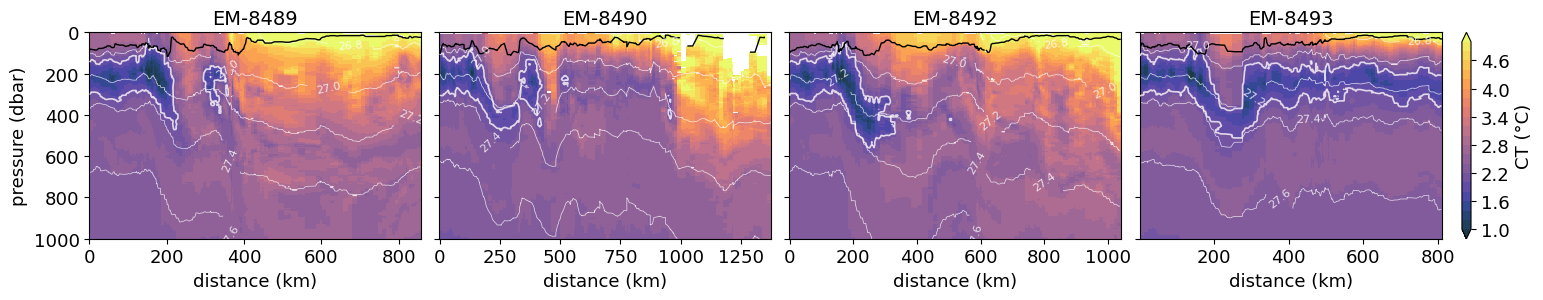

In [54]:
fig, ax = plt.subplots(1, 4, sharey = True, figsize = (15, 3.2))
axs = ax.flatten()

i = 0
for floatid in floatids:
    nonans = np.where(~np.isnan(CT[floatid].mean(dim = 'pressure', skipna = True)))[0][1:]
    im = CT[floatid][nonans].plot(ax = axs[i], x = 'distance',  cmap = cmocean.cm.thermal, levels = np.arange(1, 5.2, 0.2),
                                           alpha = 0.9, add_colorbar = False)
    
    mld[floatid].plot(ax = axs[i], c = 'k', linewidth = 1, zorder = 4)
    
    CS = dens[floatid].plot.contour(ax = axs[i], x = 'distance', colors = 'w', linewidths = 0.5, 
                                            levels = levels, alpha = 0.8)
    
    isotherm = np.arange(2,2.05,0.1)
    CT[floatid].plot.contour(ax = axs[i], x = 'distance', colors = 'snow', linewidths = 1.2, alpha = 0.8,
                             levels = isotherm, linestyles = 'solid', zorder = 3)

    
    axs[i].clabel(CS, inline=True, fontsize=8, fmt = '%1.1f')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    axs[i].set_ylim(0,1000)

    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel('pressure (dbar)')
axs[1].set_xlabel('distance (km)')

plt.tight_layout(w_pad = 0.03)

divider = make_axes_locatable(axs[3])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = 'CT (°C)', extend = 'both')

In [55]:
# settings.save_figure(fig, my_path, 'Float_CT.png', dpi = 600, pad = 0.2)

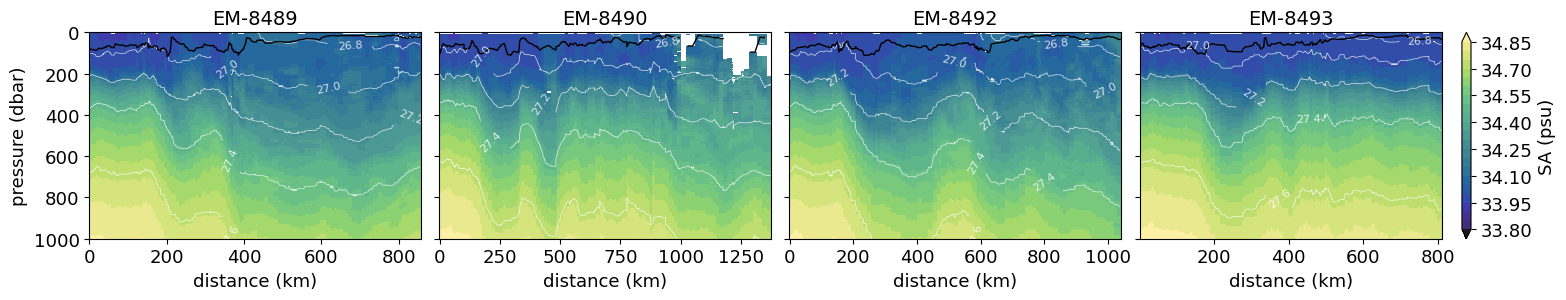

In [56]:
fig, ax = plt.subplots(1, 4, sharey = True, figsize = (15, 3.2))
axs = ax.flatten()

i = 0
for floatid in floatids:
    nonans = np.where(~np.isnan(SA[floatid].mean(dim = 'pressure', skipna = True)))[0][1:]
    im = SA[floatid][nonans].plot(ax = axs[i], x = 'distance',  cmap = cmocean.cm.haline, alpha = 0.9,
                                            levels = np.arange(33.8, 34.85, 0.05), add_colorbar = False)
    
    mld[floatid].plot(ax = axs[i], c = 'k', linewidth = 1, zorder = 4)
    
    CS = dens[floatid].plot.contour(ax = axs[i], x = 'distance', colors = 'w', linewidths = 0.5, 
                                            levels = levels, alpha = 0.8)

    
    axs[i].clabel(CS, inline=True, fontsize=8, fmt = '%1.1f')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    axs[i].set_ylim(0,1000)

    
    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel('pressure (dbar)')
axs[1].set_xlabel('distance (km)')

plt.tight_layout(w_pad = 0.03)

divider = make_axes_locatable(axs[3])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = 'SA (psu)', extend = 'both')

In [57]:
# settings.save_figure(fig, my_path, 'Float_SA.png', dpi = 600, pad = 0.2)

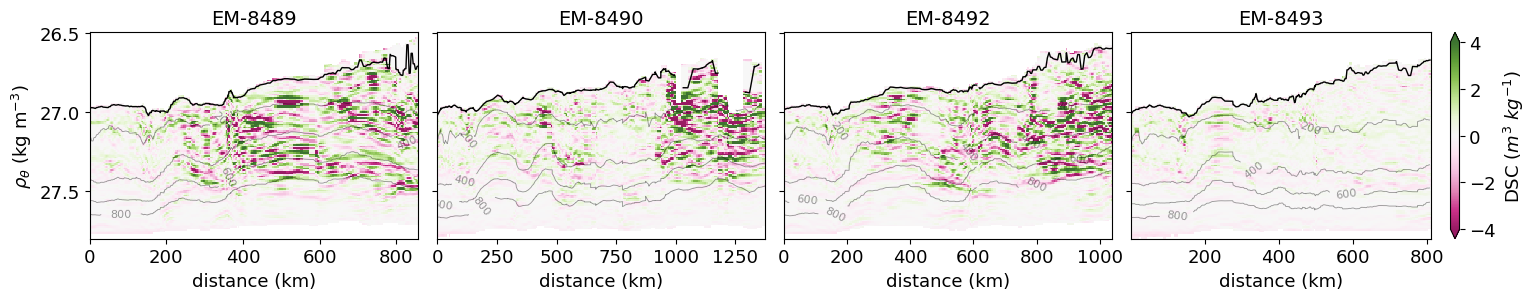

In [58]:
# DSC
fig, ax = plt.subplots(1, 4, sharey = True, figsize = (15, 3.2))
axs = ax.flatten()

i = 0
for floatid in floatids:
    nonans = np.where(~np.isnan(DSC_smooth[floatid].mean(dim = 'potential_density', skipna = True)))[0][1:]
    im = DSC_smooth[floatid][nonans].plot(ax = axs[i], x = 'distance', cmap = 'PiYG', vmin = -4, vmax = 4, 
                                   alpha = 0.9, add_colorbar = False)

    mld_on_d[floatid].plot(ax = axs[i], c = 'k', linewidth = 1, zorder = 4)
    
    CS = p_on_dens[floatid].plot.contour(ax = axs[i],
                                        x = 'distance', 
                                        levels = np.arange(0, 1000, 200),
                                        linewidths = 0.6, 
                                        colors = 'k', 
                                        alpha = 0.4)
    
    axs[i].clabel(CS, inline=True, fontsize=8, fmt = '%1.0f')

    axs[i].set_ylabel('')
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)

    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel(r'$\rho_{\theta}$ (kg m$^{-3}$)')
axs[1].set_xlabel('distance (km)')

plt.tight_layout(w_pad = 0.03)

divider = make_axes_locatable(axs[3])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = "DSC ($m^{3}$ $kg^{-1}$)", extend = 'both')

In [59]:
# settings.save_figure(fig, my_path, 'Float_DSC.png', dpi = 600, pad = 0.2)

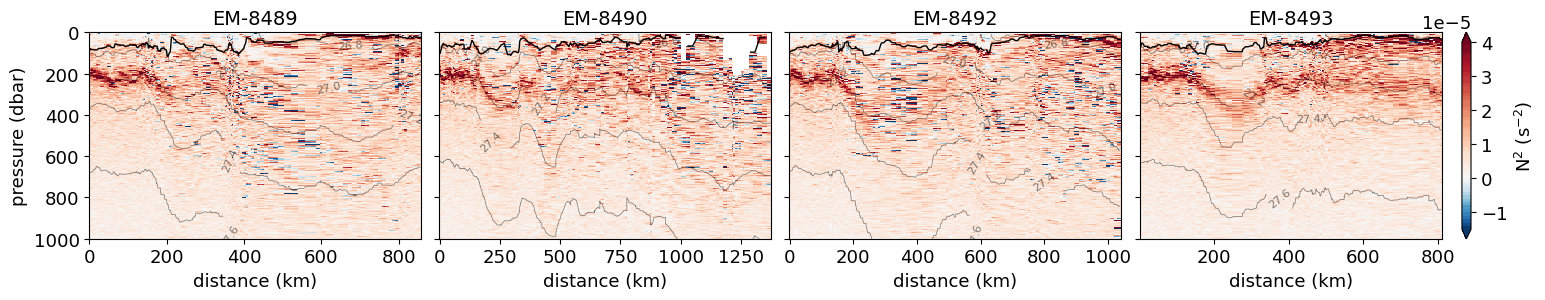

In [60]:
# N2
vmin, vmax = -1.5e-5, 4e-5
norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

fig, ax = plt.subplots(1, 4, sharey = True, figsize = (15, 3.2))
axs = ax.flatten()

i = 0
for floatid in floatids:
    nonans = np.where(~np.isnan(N2[floatid].mean(dim = 'pressure', skipna = True)))[0][1:]
    im = N2[floatid][nonans].plot(ax = axs[i], x = 'distance', norm = norm, 
                        levels = np.arange(vmin,vmax, 1e-6), cmap = 'RdBu_r', add_colorbar = False)
    
    mld[floatid].plot(ax = axs[i], c = 'k', linewidth = 1, zorder = 4)
    
    CS = dens[floatid].plot.contour(ax = axs[i], x = 'distance', colors = 'k', linewidths = 0.5, 
                                            levels = levels, alpha = 0.5)

    
    axs[i].clabel(CS, inline=True, fontsize=8, fmt = '%1.1f')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    axs[i].set_ylim(0,1000)

    
    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel('pressure (dbar)')
axs[1].set_xlabel('distance (km)')

plt.tight_layout(w_pad = 0.03)

divider = make_axes_locatable(axs[3])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = 'N$^{2}$ (s$^{-2}$)', extend = 'both')

In [61]:
# settings.save_figure(fig, my_path, 'Float_N2.png', dpi = 600, pad = 0.2)

In [2]:
# N2_8492 = xr.zeros_like(N2[8492])*np.nan
# p = ds[8492].pressure[0:-3]
# lat = ds[8492].latitude

# for prof in range(0, len(CT[8492])):
#     for i in range(0, len(p)):
#         N2_8492[prof, i] = gsw.Nsquared(SA[8492][prof, i:i+3:2], CT[8492][prof, i:i+3:2], p[i:i+3:2], lat[prof])[0][0]

In [1]:
# fig, ax = plt.subplots(figsize= (8, 3))
# N2_8492.plot(y = 'pressure', levels = np.arange(vmin,vmax, 1e-6), norm = norm, cmap = 'RdBu_r')
# ax.invert_yaxis()

Text(0.5, 1.0, '')

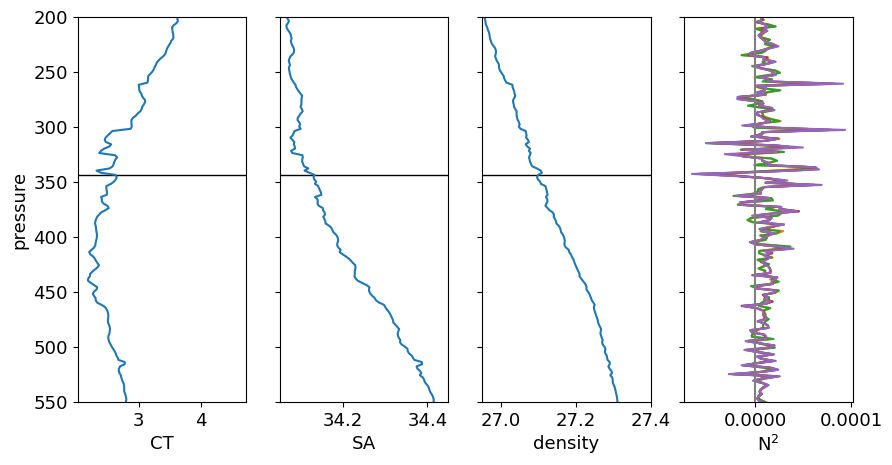

In [28]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey = True, figsize = (10,  5))
CT[8492].sel(distance = 390, method = 'nearest').plot(ax = ax1, y = 'pressure', c = 'tab:blue')
ax1.set_ylim(200, 550)
ax1.invert_yaxis()

SA[8492].sel(distance = 390, method = 'nearest').plot(ax = ax2, y = 'pressure', c = 'tab:blue')
ax2.set_xlim(34.05, 34.45)
ax2.set_ylabel('')

dens[8492].sel(distance = 390, method = 'nearest').plot(ax = ax3, y = 'pressure', zorder = 1)
ax3.set_xlim(26.95, 27.4)
ax3.set_xlabel('density')
ax3.set_ylabel('')

N2[8492].sel(distance = 390, method = 'nearest').plot(ax = ax4, y = 'pressure', zorder = 1)
N2[8492][105].plot(ax = ax4, y = 'pressure', zorder = 1)
N2[8492][106].plot(ax = ax4, y = 'pressure', zorder = 1)
N2[8492][107].plot(ax = ax4, y = 'pressure', zorder = 1)
N2[8492][108].plot(ax = ax4, y = 'pressure', zorder = 1)
ax4.axvline(x = 0, c = 'grey')
ax4.set_xlabel(r'N$^{2}$')
ax4.set_ylabel('')

ax1.axhline(y = 344, c = 'k', zorder = 0, linewidth = 1)
ax2.axhline(y = 344, c = 'k', zorder = 0, linewidth = 1)
ax3.axhline(y = 344, c = 'k', zorder = 0, linewidth = 1)

ax1.set_title('')
ax2.set_title('')
ax3.set_title('')
ax4.set_title('')

In [27]:
pdens_mid = pdens.interp(pressure = N2[floatid].pressure)
N2_ct_dens, end_dist, N2_rs_dens = ct.concatenated_flts(N2, floatids, interp_to_dens = True, pdens = pdens_mid, new_dim = True)

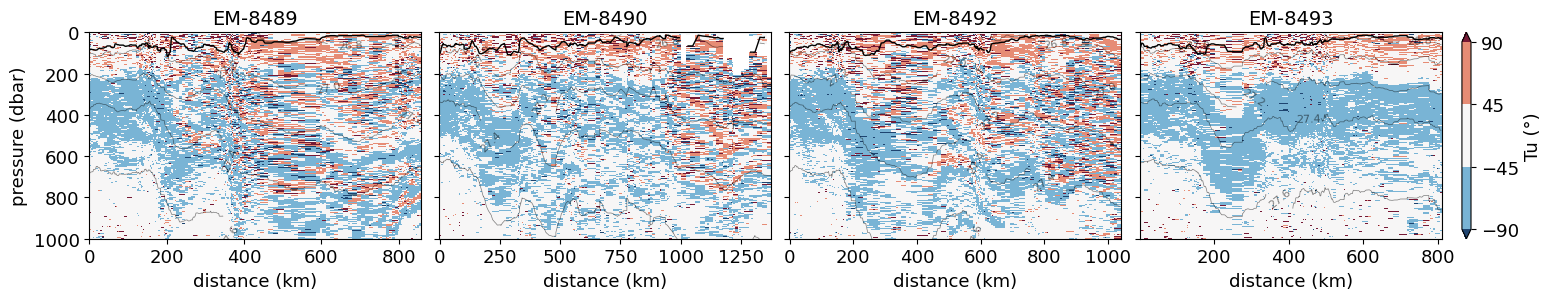

In [62]:
# Turner Angle
levs = [-180, -125, -90, -75, -45, 45, 75, 90, 125, 180]
levs = [-90, -45, 45, 90]

fig, ax = plt.subplots(1, 4, sharey = True, figsize = (15, 3.2))
axs = ax.flatten()

i = 0
for floatid in floatids:
    nonans = np.where(~np.isnan(Tu[floatid].mean(dim = 'pressure', skipna = True)))[0][1:]
    im = Tu[floatid][nonans].plot(ax = axs[i], x = 'distance', levels = levs, cmap  = 'RdBu_r', alpha = 0.9, add_colorbar = False)

    mld[floatid].plot(ax = axs[i], c = 'k', linewidth = 1, zorder = 4)
    
    CS = dens[floatid].plot.contour(ax = axs[i], x = 'distance', colors = 'k', linewidths = 0.5, 
                                            levels = levels, alpha = 0.5)

    
    axs[i].clabel(CS, inline=True, fontsize=8, fmt = '%1.1f')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('distance (km)')
    axs[i].set_title(f'EM-{floatid}', fontsize = 14)
    axs[i].set_ylim(0,1000)

    
    i+=1

axs[0].invert_yaxis()
axs[0].set_ylabel('pressure (dbar)')
axs[1].set_xlabel('distance (km)')

plt.tight_layout(w_pad = 0.03)

divider = make_axes_locatable(axs[3])
cax = divider.append_axes('right', size="3%", pad=0.2)
plt.colorbar(im, cax, label = 'Tu (°)')

In [63]:
# settings.save_figure(fig, my_path, 'Float_Tu_new_cbar.png', dpi = 600, pad = 0.2)

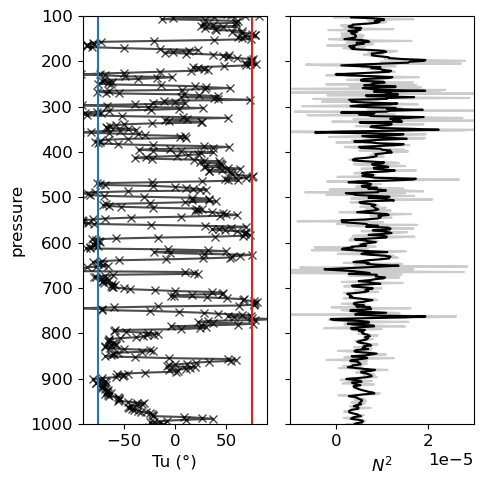

In [24]:
floatid = 8489
d1 = 500

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (5,5))
Tu[floatid].sel(distance = d1, 
                method = 'nearest').rolling(pressure = 3, 
                                            center = True).mean().plot(ax = ax1, 
                                                                       y = 'pressure',  
                                                                       marker = 'x', 
                                                                       c = 'k', 
                                                                       alpha = 0.7)
ax1.set_ylim(100, 1000)
ax1.set_xlim(-90,90)
ax1.axvline(x = -75, c = 'tab:blue')
ax1.axvline(x = 75, c = 'tab:red')
ax1.invert_yaxis()
ax1.set_title('')
ax1.set_xlabel('Tu (°)')

N2[floatid].sel(distance = d1, method = 'nearest').plot(ax = ax2, 
                                                        y = 'pressure', 
                                                        c = 'k', 
                                                        alpha = 0.2)
N2[floatid].sel(distance = d1, 
                method = 'nearest').rolling(pressure = 3, 
                                            center = True).mean().plot(ax = ax2, y = 'pressure',  
                                                                       c = 'k')
ax2.set_xlim(-1e-5,3e-5)
ax2.set_title('')
ax2.set_xlabel('$N^{2}$')
ax2.set_ylabel('')

plt.tight_layout()

### Individual floats

In [31]:
floatid = 8490
d1, d2 = 1030, 1080

In [32]:
np.where(T_dens[floatid].distance > d1)[0][0]

223

In [33]:
prof = 243

t = T_dens[floatid][prof]
s = S_dens[floatid][prof]
col = DSC_smooth[floatid][prof]

ti, si, dens_contour = calc.tsDensContour(s, t)

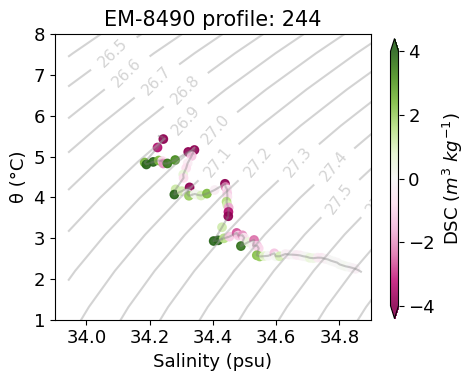

In [34]:
fig, ax = plt.subplots(figsize = (4,4))

ax.plot(s,t, alpha = 0.4, c ='grey')
im = ax.scatter(s, t, c = col, cmap = 'PiYG', alpha = 0.9, vmin = -4, vmax = 4)

CS = ax.contour(si, ti, dens_contour, levels = np.arange(26.4, 27.9, 0.1), colors='darkgrey', alpha = 0.5)
plt.clabel(CS, inline=1, fontsize=11, fmt = '%1.1f')

ax.set_title(f'EM-{floatid} profile: {prof+1}', fontsize = 15)
ax.set_ylabel('\u03B8 (\N{DEGREE SIGN}C)')
ax.set_xlabel('Salinity (psu)')
ax.set_xlim(33.9, 34.9)
ax.set_ylim(1, 8)


plt.tight_layout(w_pad = 1.2)

cax = plt.axes([1, 0.18, 0.02, 0.7])
plt.colorbar(im, cax = cax,label =('DSC ($m^{3}$ $kg^{-1}$)'), extend = 'both')

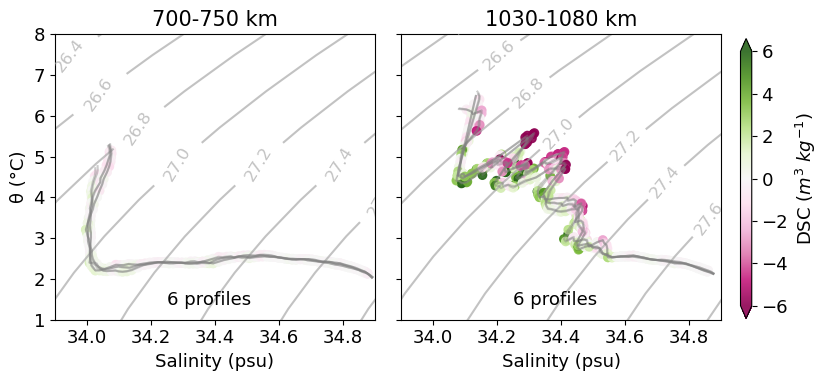

In [40]:
floatid = 8490

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, sharex = True, 
                               figsize = (7.5,4))

d1, d2 = 700, 750

t = T_dens[floatid].sel(distance = slice(d1, d2))
s = S_dens[floatid].sel(distance = slice(d1, d2))
ti, si, dens_contour = calc.tsDensContour(s, t)
col = DSC_smooth[floatid].sel(distance = slice(d1, d2))

for i in range(0,len(t)):
    ax1.plot(s[i], t[i], alpha = 0.4, c ='grey')
    im = ax1.scatter(s[i], t[i], c = col[i], cmap = 'PiYG', alpha = 0.9, vmin = -6, vmax = 6)

CS = ax1.contour(si, ti, dens_contour, levels = np.arange(26.4, 27.9, 0.2), colors='darkgrey', alpha = 0.7)
plt.clabel(CS, inline=1, fontsize=12, fmt = '%1.1f')
ax1.text(0.35, 0.05,f'{len(t)} profiles',transform=ax1.transAxes)
    
ax1.set_title(f'{d1}-{d2} km', fontsize = 15)
ax1.set_ylabel('\u03B8 (\N{DEGREE SIGN}C)')
ax1.set_xlabel('Salinity (psu)')
ax1.set_xlim(33.9, 34.9)
ax1.set_ylim(1, 8)

d11, d22 = 1030, 1080

t = T_dens[floatid].sel(distance = slice(d11, d22))
s = S_dens[floatid].sel(distance = slice(d11, d22))
ti, si, dens_contour = calc.tsDensContour(s, t)
col = DSC_smooth[floatid].sel(distance = slice(d11, d22))

for i in range(0,len(t)):
    ax2.plot(s[i],t[i], alpha = 0.4, c ='grey')
    im = ax2.scatter(s[i], t[i], c = col[i], cmap = 'PiYG', alpha = 0.9, vmin = -6, vmax = 6)
    
ax2.text(0.35, 0.05,f'{len(t)} profiles',transform=ax2.transAxes)
CS = ax2.contour(si, ti, dens_contour, levels = np.arange(26.4, 27.9, 0.2), colors='darkgrey', alpha = 0.7)
plt.clabel(CS, inline=1, fontsize=12, fmt = '%1.1f')

ax2.set_title(f'{d11}-{d22} km', fontsize = 15)
ax2.set_xlabel('Salinity (psu)')

plt.tight_layout(w_pad = 1.2)

cax = plt.axes([1, 0.18, 0.015, 0.7])
plt.colorbar(im, cax = cax,label =('DSC ($m^{3}$ $kg^{-1}$)'), extend = 'both')

# settings.save_figure(fig, my_path, f'EM-{floatid}_TS_diagram.png', dpi = 600, pad = 0.2)

In [41]:
# mean_p = p_on_dens[floatid].mean(dim = 'distance', skipna = True)
# stretched_p = xr.DataArray(np.tile(mean_p, (len(DSC_smooth[floatid]), 1)), dims = DSC_smooth[floatid].dims, 
#                            coords = DSC_smooth[floatid].coords)
# stretched_p

Text(0.5, 1.0, 'EM-8490')

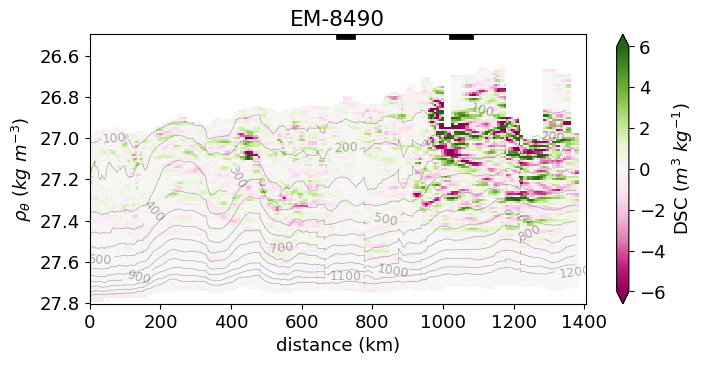

In [42]:
fig, ax = plt.subplots(figsize = (8,3.5))
DSC_smooth[floatid].plot(x = 'distance', vmin = -6, vmax = 6, cmap = 'PiYG',
                        cbar_kwargs = dict(label = 'DSC ($m^{3}$ $kg^{-1}$)'))

CS = p_on_dens[floatid].plot.contour(x = 'distance', 
                                    levels = np.arange(0, 1300, 100),
                                    linewidths = 0.5, 
                                    colors = 'k', 
                                    alpha = 0.3)

ax.clabel(CS, inline=True, fontsize=9, fmt = '%1.0f')

d = DSC_smooth[floatid].distance.sel(distance = slice(d1,d2))
plt.plot(d, 0*np.arange(0, len(d))+26.5, c = 'k', linewidth = 7)

d = DSC_smooth[floatid].distance.sel(distance = slice(d11,d22))
plt.plot(d, 0*np.arange(0, len(d))+26.5, c = 'k', linewidth = 7)

ax.invert_yaxis()

ax.set_ylabel(r'$\rho_{\theta}$ ($kg$ $m^{-3})$')
ax.set_xlabel('distance (km)')
plt.title(f'EM-{floatid}')

# settings.save_figure(fig, my_path, f'EM-{floatid}_DSC_section.png', dpi = 600, pad = 0.2)

In [43]:
floatid =  8489 #8493 #8492 #8490
d1, d2 =   375,575 #200,400 #700,1100 #900,1350
pd1, pd2 = 26.9, 27.4

i1 = np.where(ds[floatid].distance >= d1)[0][0]
i2 = np.where(ds[floatid].distance <= d2)[0][-1]+1

no_ticks = 4
tick_start = 8 #2

t = ds[floatid].time[i1:i2].dt.strftime("%m-%d\nT%H:%M")
tickinterval = int(len(t)/no_ticks)
print(tickinterval)

10


In [44]:
## evenly grid in distance (3 km intervals)
dsc_even_grid = interp.even_dist_grid(DSC_smooth[floatid], 3)
pres_dens = interp.even_dist_grid(p_on_dens[floatid], 3)

Text(0.5, 1.0, 'EM-8489')

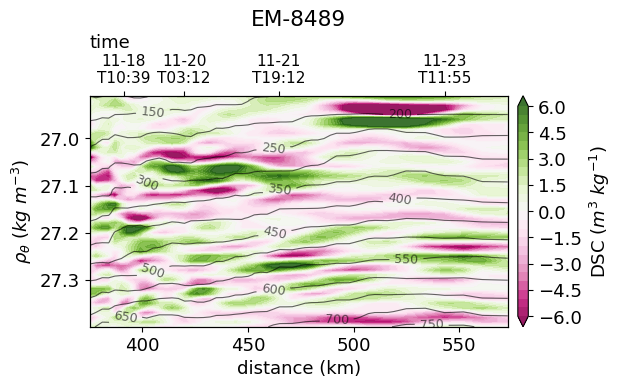

In [45]:
dsc_sel = dsc_even_grid.sel(potential_density = slice(pd1, pd2), 
                        distance = slice(d1,d2))

fig, ax = plt.subplots(figsize = (6.5,3))
dsc_sel.plot.contourf(x = 'distance', cmap = 'PiYG', 
                      cbar_kwargs = dict(label = 'DSC ($m^{3}$ $kg^{-1}$)', pad = 0.02),
                      levels = np.arange(-6,6.5, 0.5),
                       alpha = 0.9)

CS = pres_dens.sel(potential_density = slice(pd1, pd2), 
                            distance = slice(d1,d2)).plot.contour(ax = ax, 
                                x = 'distance', 
                                levels = np.arange(50, 800, 50),
                                linewidths = 0.8, 
                                colors = 'k', 
                                alpha = 0.6)

ax.clabel(CS, inline=True, fontsize=9, fmt = '%1.0f')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ds[floatid].distance.sel(distance = slice(d1,d2)).distance[tick_start:-1:tickinterval])
ax2.set_xticklabels(t.data[tick_start:-1:tickinterval], multialignment='center', fontsize = 11)
ax2.set_xlabel('time', loc = 'left')

ax.invert_yaxis()
ax.set_xlabel('distance (km)')
ax.set_ylabel(r'$\rho_{\theta}$ ($kg$ $m^{-3})$')
plt.title(f'EM-{floatid}')

# settings.save_figure(fig, my_path, f'DSC_sel_EM-{floatid}.png', dpi = 600, pad = 0.2)

Text(0.5, 1.0, 'EM-8490')

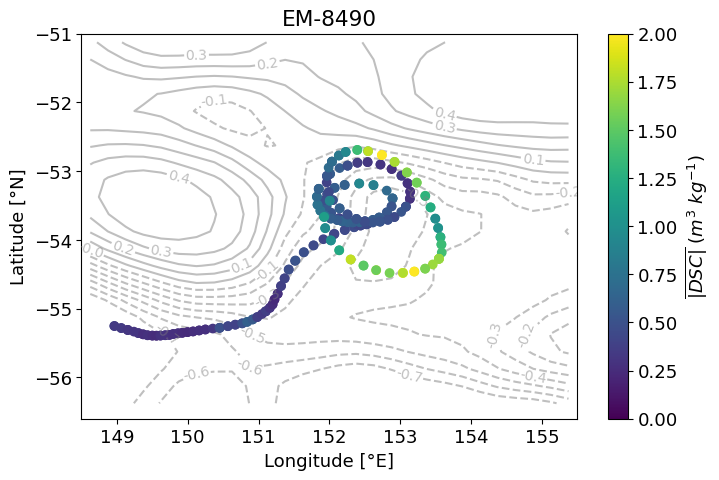

In [46]:
floatid = 8490
depth_avg_dsc = abs(DSC_smooth[floatid]).mean(dim = 'potential_density')

fig, ax = plt.subplots(figsize = (8,5))
im, msl = plots.colTrajectory(ax, depth_avg_dsc, ema[floatid], floatid, alt_cmems, rs = True, 
                              cmap = 'viridis', vmin = 0, vmax = 2)

plt.colorbar(im, label = '$\overline{|DSC|}$ ($m^{3}$ $kg^{-1}$)')
plt.title(f'EM-{floatid}')

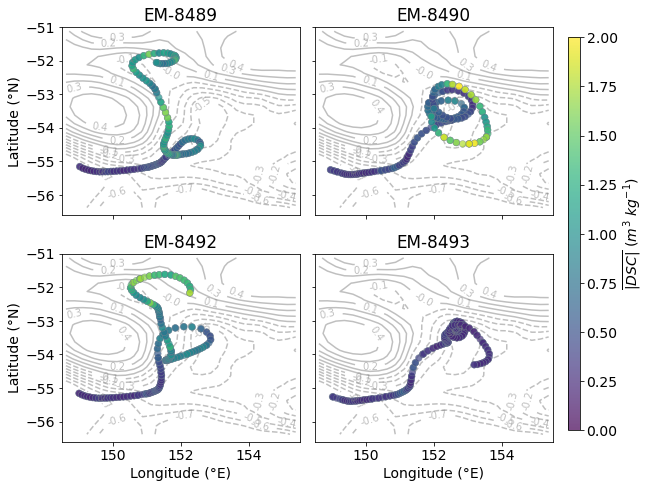

In [113]:
imp.reload(plots)

label = '$\overline{|DSC|}$ ($m^{3}$ $kg^{-1}$)'
vmin, vmax = 0, 2

fig, ax = plt.subplots(2, 2, sharex = True, sharey = True, figsize = (8,7))
axs = ax.flatten()
                                          
floatids = [8489, 8490, 8492, 8493]
i = 0
for floatid in floatids: 
    float_num = ema[floatid]
    
    rms_dsc = np.sqrt((data_dict[floatid]**2))
    depth_avg_dsc = abs(DSC_smooth[floatid]).mean(dim = 'potential_density')
    
    im, msl = plots.colTrajectory(axs[i], depth_avg_dsc, float_num, floatid, alt_cmems, msl_contours = True,
                                  cmap = 'viridis', vmin = vmin, vmax = vmax, s = 45,
                                  alpha = 0.7, edgecolors='slategrey', linewidth = 0.5)

    axs[i].set_title(f'EM-{floatid}')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    if i in [0, 2]:
        axs[i].set_ylabel('Latitude (°N)')
    if i in [2, 3]:
        axs[i].set_xlabel('Longitude (°E)')
        
    i += 1

plt.tight_layout(w_pad = 0.8)
cbar_ax = fig.add_axes([1, 0.13, 0.02, 0.78])
cbar = fig.colorbar(im, cax=cbar_ax, label = label)

### Spatial distribution of DSC layers

In [30]:
# pdens_mid = pdens.interp(pressure = N2[floatid].pressure)
# N2_ct_dens, end_dist, N2_rs_dens = ct.concatenated_flts(N2, floatids, interp_to_dens = True, pdens = pdens_mid, new_dim = True)
# Tu_ct_dens, end_dist, Tu_rs_dens = ct.concatenated_flts(Tu, floatids, interp_to_dens = True, pdens = pdens_mid, new_dim = True)

In [168]:
pdens_concat = ct.joinFloats(dens, 'distance', new_dim = True)

In [169]:
mld_on_d = {}
for floatid in floatids:
    mld_on_d[floatid] = calc.MLD_on_dens(dens[floatid], criteria = 0.03, pref = 10, dz = 10) #dz = 10 dbar below ML

In [170]:
mld_concat = ct.joinFloats(mld_on_d, 'distance', new_dim = True)
dyn_m_concat = ct.joinFloats(dyn_m, 'distance', new_dim = True)
adt_concat = ct.joinFloats(adt_interp, 'distance', new_dim = True)

DSC_concat = ct.joinFloats(DSC_smooth, 'distance', new_dim = True)
T_concat = ct.joinFloats(CT, 'distance', new_dim = True)
N2_concat = ct.joinFloats(N2, 'distance', new_dim = True)

In [171]:
# mean below the mixed layer to 27.5 (average data in pressure coordinates)
dens_min = mld_concat
dens_max = np.tile(27.5, len(mld_concat))

avg_T = calc.average_in_density_on_pgrid(T_concat, pdens_concat.data, dens_min.data, dens_max)
avg_N2 = calc.average_in_density_on_pgrid(N2_concat, pdens_concat.data, dens_min.data, dens_max)

In [172]:
# mean below the mixed layer to 27.5 (average data in density coordinates)
avg_dsc = calc.mean_below_ml(abs(DSC_concat), mld_concat, zmax = 27.5)

Text(0, 0.5, 'DSC')

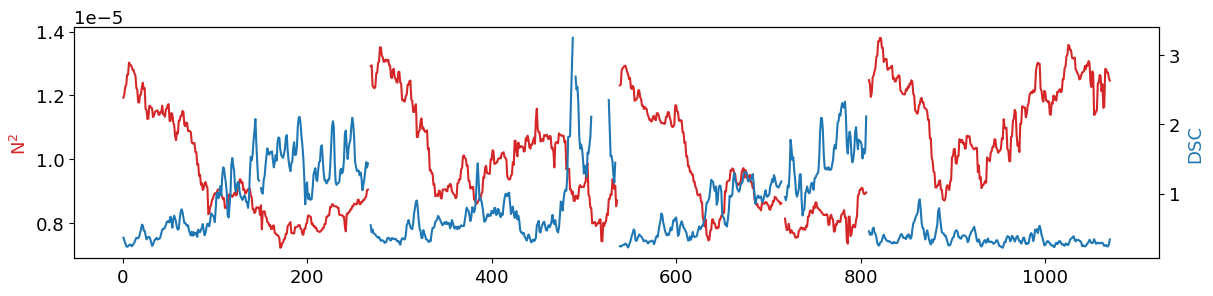

In [173]:
fig, ax = plt.subplots(figsize = (14,3))
plt.plot(avg_N2, c = 'tab:red')
ax.set_ylabel('N$^{2}$', c = 'tab:red')
ax2 = ax.twinx()
ax2.plot(avg_dsc)
ax2.set_ylabel('DSC', c = 'tab:blue')

Pearsons corr: 0.836, p-value: 9.44e-273
Pearsons corr: -0.724, p-value: 2.12e-169
Pearsons corr: 0.814, p-value: 3.68e-246


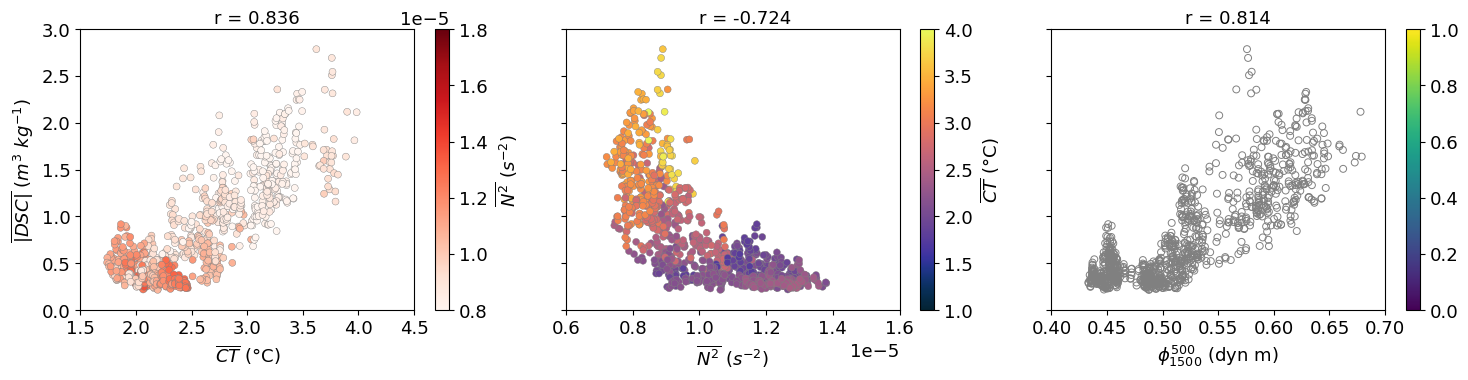

In [175]:
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (15,4))

axs = ax.flatten()

x = avg_T
y = avg_dsc
c = avg_N2

im = axs[0].scatter(x, y, c = c, s= 25, cmap = 'Reds', vmin = 0.8e-5, vmax = 1.8e-5,
                 edgecolors = 'grey', linewidth = 0.3)

axs[0].set_ylim(0, 3)
axs[0].set_xlim(1.5, 4.5)
axs[0].set_ylabel('$\overline{|DSC|}$ ($m^{3}$ $kg^{-1}$)')
axs[0].set_xlabel('$\overline{CT}$ (\N{DEGREE SIGN}C)')
plt.colorbar(im, ax = axs[0], label = '$\overline{N^{2}}$ $(s^{-2})$')

r, p = stats.pearsons(x, y, print_info = True)
axs[0].text(0.4, 1.02, f'r = {r:.3f}', transform = axs[0].transAxes)


x = avg_N2
y = avg_dsc
c = avg_T

im1 = axs[1].scatter(x, y, c = c, s = 25, cmap = cmocean.cm.thermal, vmin = 1, vmax = 4,
                                     edgecolors = 'grey', linewidth = 0.3)

axs[1].set_xlim(0.6e-5, 1.6e-5)
axs[1].set_xlabel('$\overline{N^{2}}$ $(s^{-2})$')
axs[1].set_ylabel('')
plt.colorbar(im1, ax = axs[1], label = '$\overline{CT}$ (\N{DEGREE SIGN}C)')

r, p = stats.pearsons(x, y, print_info = True)
axs[1].text(0.4, 1.02, f'r = {r:.3f}', transform = axs[1].transAxes)


x = dyn_m_concat

im2 = axs[2].scatter(x, y, s = 25, facecolors = 'none', edgecolors = 'grey', linewidth = 0.7)
    
axs[2].set_xlim(0.4, 0.7)
axs[2].set_ylabel('')
plt.colorbar(im2, ax = axs[2])
axs[2].set_xlabel('$\phi^{500}_{1500}$ (dyn m)')

r, p = stats.pearsons(x, y, print_info = True)
axs[2].text(0.4, 1.02, f'r = {r:.3f}', transform = axs[2].transAxes)

plt.tight_layout()

# settings.save_figure(fig, my_path, 'Float_DSC_scatter.png', dpi = 600, pad = 0.2)

## f/N

In [29]:
f_N = {}
N_f = {}
for floatid in floatids:
    f = gsw.f(ds[floatid].latitude)

    N = np.sqrt(N2[floatid].sel(pressure = slice(200, 500)).mean(dim = 'pressure'))
    f_N[floatid] = f.data/N
    N_f[floatid] = N/f.data
    
f_N_concat = ct.joinFloats(f_N, 'distance', new_dim = True)
N_f_concat = ct.joinFloats(N_f, 'distance', new_dim = True)
avg_f_N = np.nanmean(f_N_concat)
avg_f_N

-0.0367280362360317

Text(0.86, 1.02, 'EM-8493')

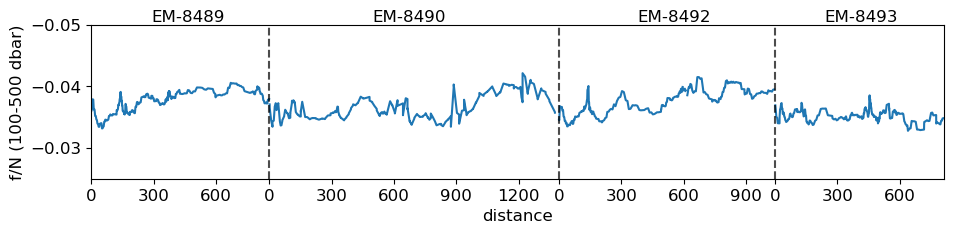

In [58]:
fig, ax = plt.subplots(figsize = (11,2))
f_N_concat.plot()

for i in range(0,len(flt_dist_loc)):
    ax.axvline(x = flt_dist_loc[i], linestyle = '--', color = 'k', alpha = 0.7)

ax.set_xticks(ticks)
ax.set_xticklabels(values)
ax.set_ylim(-0.05, -0.025)
ax.set_xlim(0, f_N_concat.distance[-1])
ax.invert_yaxis()
plt.ylabel('f/N (100-500 dbar)')

ax.text(0.07, 1.02, 'EM-8489', transform = ax.transAxes)
ax.text(0.33, 1.02, 'EM-8490', transform = ax.transAxes)
ax.text(0.64, 1.02, 'EM-8492', transform = ax.transAxes)
ax.text(0.86, 1.02, 'EM-8493', transform = ax.transAxes)

### TRIAXUS

In [58]:
my_path = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd','figures', 'chapter2_manuscript')

In [59]:
# Triaxus
datadir = os.path.join(os.sep, 'Users', 'mijakes', 'checkouts', 'phd', 'data', 'triaxus')
folder = 'in2018_v05CtdAvgTriaxus_VerticalCasts_nc'

tow_list = ['01_002', '02_002', '02_005', '03_003', '04_002', '04_003', 
       '06_002', '07_002', '08_002', '08_003', '09_002', '09_003']

triaxus_cast = imports.triaxus_data(datadir, tow_list, folder)

In [89]:
lst = ['01_002', '02_002', '03_003', '04_002', '04_003', 
       '06_002', '07_002', '08_002']

d = {}
pdens = {}

for tow in lst:
    triaxus_vertical_cast = triaxus_cast[tow]
    d[tow] = settings.distanceAsCoord(triaxus_vertical_cast, xdim = 'time')
    d[tow]['pdens'] = calc.potentialDensity(d[tow].pressure, d[tow].salinity, d[tow].temperature)
    pdens[tow] = d[tow].pdens

In [61]:
dens_levels = np.arange(26.6,27.5,0.1)

In [108]:
levs = [-125, -90, -45, 45, 90, 125]

DSC = {}
CT = {}
T_dens = {}
S_dens = {}
P_on_d = {}
spice_grad = {}
spice_on_d = {}

mld = {}
mld_on_d = {}

N2 = {}
Tu = {}

for tow in lst:
    SA = d[tow].salinity
    p = d[tow].pressure
    CT[tow] = gsw.CT_from_t(SA, d[tow].temperature, p)
    s = gsw.spiciness0(SA, CT[tow])
    spice_on_d[tow] = interp.to_pdens_grid(s, d[tow].pdens)
    spice_grad[tow] = (spice_on_d[tow].differentiate('distance')/1000)
    
    mld[tow] = calc.MLD(d[tow].pdens, criteria = 0.03, pref = 10)
    mld_on_d[tow] = calc.MLD_on_dens(d[tow].pdens, criteria = 0.03, pref = 10)
    
    Turner, R_p, p_mid = gsw.Turner_Rsubrho(SA, CT[tow], p, axis = 1)
    Tu[tow] = xr.DataArray(Turner, dims = SA.dims, coords = dict(distance = ('distance', SA.distance.data), 
                                                                  pressure = ('pressure', p_mid[0])))
    
    [n_squared, p_midarray_n2] = gsw.Nsquared(SA, CT[tow], p, axis = 1)
    N2[tow] = xr.DataArray(data = n_squared, dims = ["distance", "pressure"],coords = dict(pressure=(["pressure"], 
                                    p_midarray_n2[0]),distance=(["distance"], CT[tow].distance.data),))
    
    if tow == '02_002':
        ind = [24, 25]
        N2[tow][ind] = np.nan
        Tu[tow][ind] = np.nan
        
    DSC[tow], T_dens[tow], S_dens[tow] = calc.DSC(CT[tow], SA, pdens = d[tow].pdens, x_smooth = False)
    
    pressure = xr.DataArray(np.tile(p, (len(CT[tow].distance), 1)), dims = CT[tow].dims, coords = CT[tow].coords)
    P_on_d[tow] = interp.to_pdens_grid(pressure, d[tow].pdens, zdim = 'pressure')
    

interpolating to density grid
interpolating to density grid
interpolating to density grid
interpolating to density grid
interpolating to density grid
interpolating to density grid
interpolating to density grid
interpolating to density grid


### Tows 1, 2 and 3

In [63]:
dens_levels

array([26.6, 26.7, 26.8, 26.9, 27. , 27.1, 27.2, 27.3, 27.4])

Text(0, 0.5, '$\\overline{CT}$')

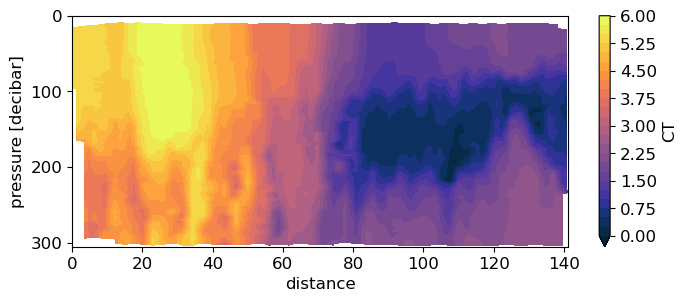

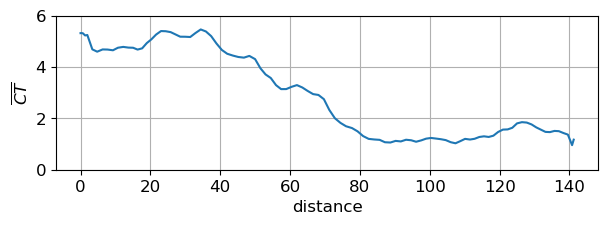

In [140]:
tow = lst[6]
SA = d[tow].salinity
p = d[tow].pressure

fig, ax = plt.subplots(figsize = (8,3))
CT[tow].plot.contourf(x = 'distance', levels = np.arange(0,6.25,0.25), cmap = cmocean.cm.thermal, cbar_kwargs = dict(label = 'CT'))
ax.invert_yaxis()

fig, ax = plt.subplots(figsize = (7,2))
CT[tow].mean(dim = 'pressure').plot()
plt.grid()
plt.ylim(0,6)
plt.ylabel(u'$\overline{CT}$')

### Tows 1, 2, 3, 4

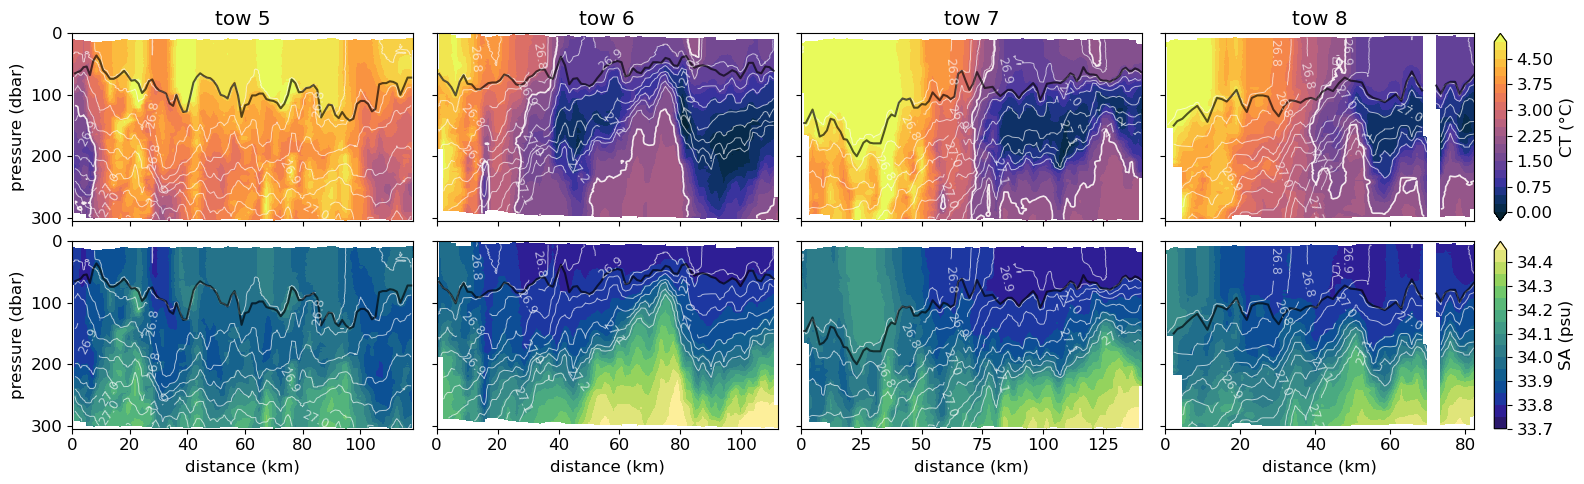

In [92]:
i = 0
tow_ind = 4 #0

fig, ax = plt.subplots(2, 4, sharey = True, figsize = (16,5))
axs = ax.flatten()

T_ax = [0, 1, 2, 3] 
S_ax = [4, 5, 6, 7]

for tow in lst[4:8]: #[0:4]
    SA = d[tow].salinity

    # Temperature
    im1 = CT[tow].plot.contourf(ax = axs[T_ax[i]], x = 'distance', levels = np.arange(0,5.25,0.25),
                                cmap = cmocean.cm.thermal, add_colorbar = False)

    CS = d[tow].pdens.plot.contour(ax = axs[T_ax[i]], x = 'distance', colors = 'w', linewidths = 0.7, 
                                             levels = dens_levels, alpha = 0.65)
    axs[T_ax[i]].clabel(CS, inline=True, fontsize=9, fmt = '%1.1f')
    
    isotherm = np.arange(2,2.05,0.1)
    CT[tow].plot.contour(ax = axs[T_ax[i]], x = 'distance', colors = 'snow', linewidths = 1.2, alpha = 0.9,
                         levels = isotherm, linestyles = 'solid')

    mld[tow].plot(ax = axs[T_ax[i]], x = 'distance', c = 'k', alpha = 0.65)
    
    axs[T_ax[i]].set_title(f'tow {tow_ind+1}')
    axs[T_ax[i]].set_xticklabels('')
        

    # Salinity
    im2 = SA.plot.contourf(ax = axs[S_ax[i]], x = 'distance', levels = np.arange(33.7, 34.5, 0.05), cmap = cmocean.cm.haline, 
             add_colorbar = False)

    CS = d[tow].pdens.plot.contour(ax = axs[S_ax[i]], x = 'distance', levels = dens_levels, 
                                   linewidths = 0.7, colors = 'w', alpha = 0.65)
    axs[S_ax[i]].clabel(CS, inline=True, fontsize=9, fmt = '%1.1f')
    
    mld[tow].plot(ax = axs[S_ax[i]], x = 'distance', c = 'k', alpha = 0.65)
    
    axs[T_ax[i]].set_xlabel('')
    axs[S_ax[i]].set_xlabel('distance (km)')

    if i == 3:
        divider = make_axes_locatable(axs[T_ax[i]])
        cax = divider.append_axes('right', size='4%', pad=0.2)
        plt.colorbar(im1, cax = cax, label = 'CT (\N{DEGREE SIGN}C)')
        
        divider = make_axes_locatable(axs[S_ax[i]])
        cax = divider.append_axes('right', size='4%', pad=0.2)
        plt.colorbar(im2, cax = cax, label = 'SA (psu)')
        
    i+=1
    tow_ind+=1
    
axs[0].invert_yaxis()
axs[T_ax[0]].set_ylabel('pressure (dbar)')
axs[S_ax[0]].set_ylabel('pressure (dbar)')
    
plt.tight_layout(h_pad = 0.5)

# settings.save_figure(fig, my_path, 'Triaxus_T_S_1.png', dpi = 600, pad = 0.2)
# settings.save_figure(fig, my_path, 'Triaxus_T_S_2.png', dpi = 600, pad = 0.2)

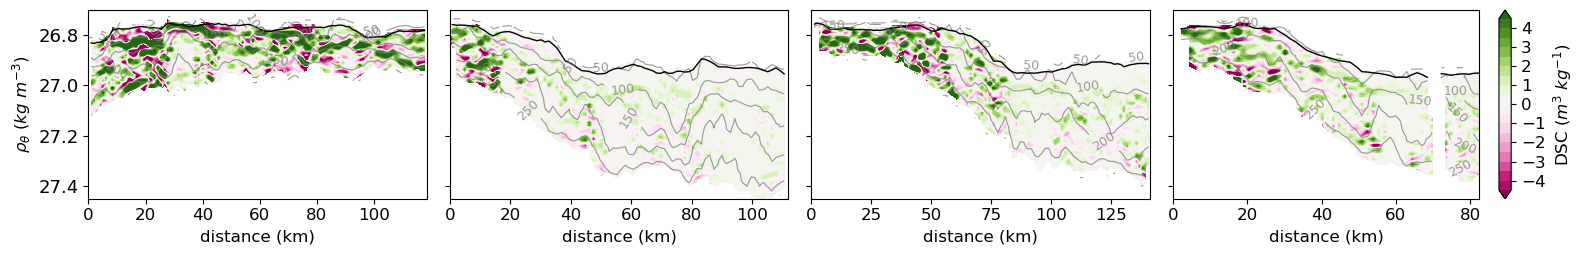

In [71]:
fig, ax = plt.subplots(1, 4, sharey = True, figsize = (16,2.7))
axs = ax.flatten()

i = 0
for tow in lst[4:8]:
    
    # DSC
    im1 = DSC[tow].plot.contourf(ax = axs[i], x = 'distance', levels = np.arange(-4.5, 5, 0.5), cmap = 'PiYG',
                            add_colorbar = False)
    
    CS = P_on_d[tow].plot.contour(ax = axs[i], x = 'distance', levels = np.arange(50, 350, 50), linewidths = 0.8, 
                                  colors = 'grey', alpha = 0.8)
    
    axs[i].clabel(CS, inline=True, fontsize=9, fmt = '%1.0f')
    
    mld_on_d[tow].plot(ax = axs[i], c = 'k', linewidth = 1)
    
#     axs[i].set_title(f'tow {i+1}')
    axs[i].set_ylim(26.7, 27.45)
    axs[i].tick_params(axis='y',labelsize=13)
    
#     axs[0].set_ylim(26.7, 27.2)
#     axs[0].set_yticks([26.8, 26.9, 27.0, 27.1])
#     axs[3].set_xticks([0, 20, 40, 60, 80])
    
    axs[i].set_xlabel('distance (km)')
    axs[i].set_ylabel('')
#     axs[i].invert_yaxis()

    axs[0].set_ylabel(r'$\rho_{\theta}$ ($kg$ $m^{-3})$')
    
    if i == 3:
        divider = make_axes_locatable(axs[i])
        cax = divider.append_axes('right', size='4%', pad=0.2)
        plt.colorbar(im1, cax = cax, label = 'DSC ($m^{3}$ $kg^{-1}$)')

    i+=1

axs[0].invert_yaxis()
plt.tight_layout(h_pad = 0.5)
# plt.tight_layout(h_pad = 0.5, w_pad = 0.3)

# settings.save_figure(fig, my_path, f'Triaxus_DSC_1.png', dpi = 600, pad = 0.2)
# settings.save_figure(fig, my_path, f'Triaxus_DSC_2.png', dpi = 600, pad = 0.2)

### Along-isopycnal spice spectra

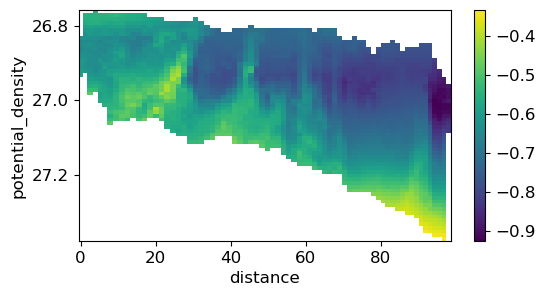

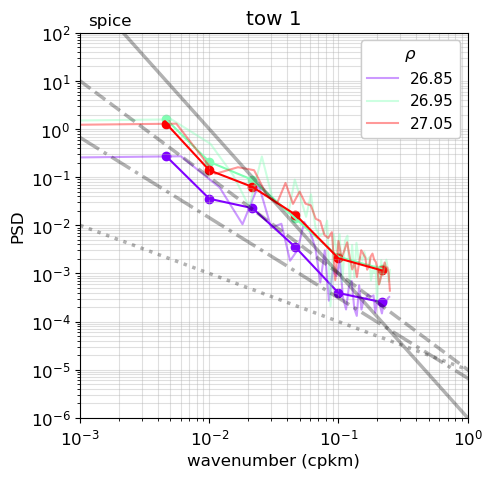

In [281]:
imp.reload(plots)

i = 0
tow = lst[i]
section = spice_on_d[tow]

fig, ax = plt.subplots(figsize = (6, 3))
section.plot(x = 'distance')
ax.invert_yaxis()

dens = np.asarray([26.85, 26.95, 27.05])

ax = plots.power_spectra(section, f'tow {i+1}', dim = 'potential_density', lst = dens, sections = None, return_slopes = False,
                  label = 'spice', legend = True, whiten = False, ymin = 10**-6, ymax = 10**2, powerlaw = False)

Along-isopycnal variations in spice indicate the presence of lateral stirring.

$k^{-1}$ spectral slope (dotted) is associated with quasigeostrophic turbulence.

Steeper spectral slopes $k^{-2}$ (dashed) and $k^{-3}$ (solid) suggest the presence of frontogenesis and ageostrophic dynamics.

### Turner angle and stratification

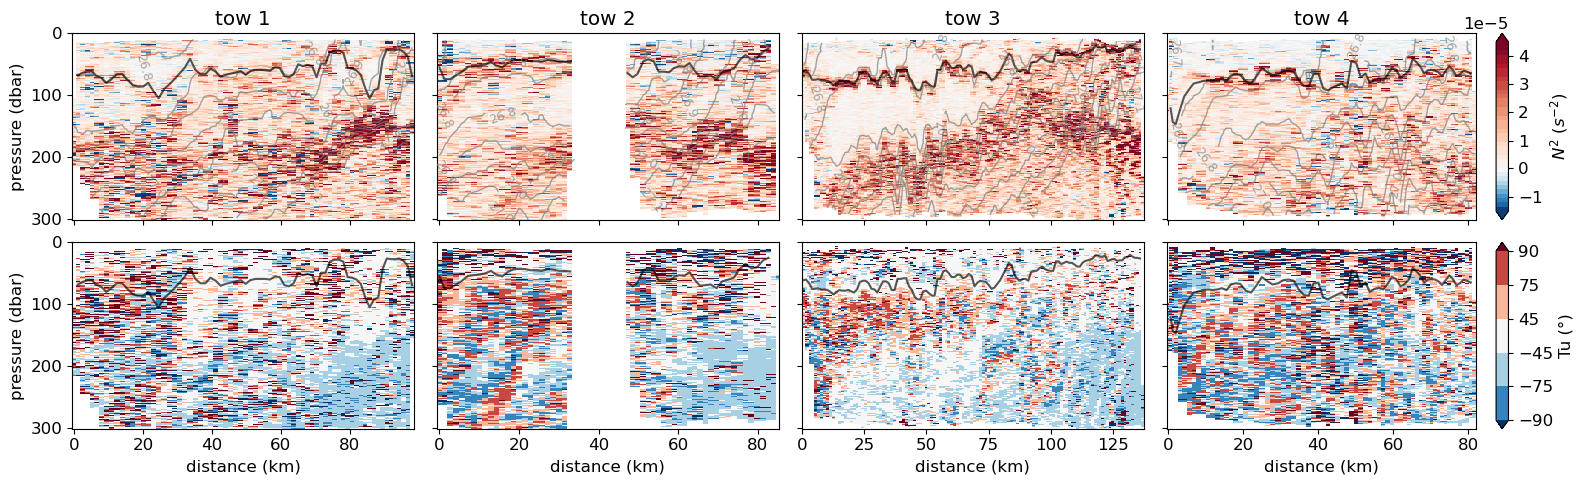

In [78]:
i = 0

fig, ax = plt.subplots(2, 4, sharey = True, figsize = (16,5))
axs = ax.flatten()

top_ax = [0, 1, 2, 3] 
bot_ax = [4, 5, 6, 7] 

vmin, vmax = -1.5e-5, 4.5e-5
norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
dens_levels = np.arange(26.6,27.2,0.04)

levs = [-90, -75, -45, 45, 75, 90]

for tow in lst[0:4]:

    # Stratification
    im1 = N2[tow].plot(ax = axs[top_ax[i]], x = 'distance', cmap = 'RdBu_r', norm = norm, levels = np.arange(vmin,vmax, 1.5e-6),
                                  add_colorbar = False)
    
    CS = d[tow].pdens.plot.contour(ax = axs[top_ax[i]], x = 'distance', colors = 'grey', linewidths = 1, 
                                                              levels = dens_levels, alpha = 0.7)
    plt.clabel(CS, inline=True, fontsize=9, fmt = '%1.1f')
    
    mld[tow].plot(ax = axs[top_ax[i]], x = 'distance', c = 'k', alpha = 0.65)

    
    axs[top_ax[i]].set_title(f'tow {i+1}')
    axs[top_ax[i]].set_xticklabels('')
        

    # Turner angle
    im2 = Tu[tow].plot(ax = axs[bot_ax[i]], x = 'distance', levels = levs, cmap  = 'RdBu_r', add_colorbar = False)

#     CS = d[tow].pdens.plot.contour(ax = axs[bot_ax[i]], x = 'distance', colors = 'grey', linewidths = 1, 
#                                                               levels = dens_levels, alpha = 0.7)
#     plt.clabel(CS, inline=True, fontsize=9, fmt = '%1.1f')
    
    mld[tow].plot(ax = axs[bot_ax[i]], x = 'distance', c = 'k', alpha = 0.65)
    
    axs[top_ax[i]].set_xlabel('')
    axs[bot_ax[i]].set_xlabel('distance (km)')

    if i == 3:
        divider = make_axes_locatable(axs[top_ax[i]])
        cax = divider.append_axes('right', size='4%', pad=0.2)
        plt.colorbar(im1, cax = cax, label = '$N^{2}$ ($s^{-2}$)')
        
        divider = make_axes_locatable(axs[bot_ax[i]])
        cax = divider.append_axes('right', size='4%', pad=0.2)
        plt.colorbar(im2, cax = cax, label = 'Tu (°)')
        
    i+=1
    
axs[0].invert_yaxis()
axs[top_ax[0]].set_ylabel('pressure (dbar)')
axs[bot_ax[0]].set_ylabel('pressure (dbar)')
    
plt.tight_layout(h_pad = 0.5)

# settings.save_figure(fig, my_path, 'Triaxus_N2_Tu_1.png', dpi = 600, pad = 0.2)

### Spatial distribution

In [83]:
mld_on_d = {}
adt_interp = {}

for tow in lst: 
    mld_on_d[tow] = calc.MLD_on_dens(d[tow].pdens, criteria = 0.03, pref = 10, dz = 10) #dz = 10 dbar below ML
    
    adt = stats.temporalError(triaxus_cast[tow], alt_cmems.adt, method = 'interp', rs = False)[0]
    adt_interp[tow] = xr.DataArray(adt.data, dims = ['distance'], coords = mld_on_d[tow].coords)

In [110]:
## join data from all triaxus tows together
dsc_concat = ct.joinFloats(DSC, dim_name = 'distance')
n2_concat = ct.joinFloats(N2, dim_name = 'distance')
t_concat = ct.joinFloats(CT, dim_name = 'distance')

dens_ct = ct.joinFloats(pdens, dim_name = 'distance')
mld_dens_ct = ct.joinFloats(mld_on_d, dim_name = 'distance')
adt_concat = ct.joinFloats(adt_interp, dim_name = 'distance')

In [140]:
# mean below the mixed layer to 27.5 kg/m3
dens_min = mld_dens_ct
dens_max = np.tile(27.5, len(dens_min))

avg_T = calc.average_in_density_on_pgrid(t_concat, dens_ct.data, dens_min.data, dens_max)
avg_N2 = calc.average_in_density_on_pgrid(n2_concat, dens_ct.data, dens_min.data, dens_max)

In [141]:
# average below the mixed layer
avg_dsc = calc.mean_below_ml(abs(dsc_concat), mld_dens_ct, zmax = 27.5, zdim = 'potential_density')

avg_spice_grad = calc.mean_below_ml(abs(spice_grad_concat), mld_dens_ct, zmax = 27.5, zdim = 'potential_density')
# avg_N2 = calc.mean_below_ml(n2_concat, mld_dens_ct, zmax = 27.5, zdim = 'potential_density')
# avg_T = calc.mean_below_ml(t_concat, mld_dens_ct, zmax = 27.5, zdim = 'potential_density')

Pearsons corr: 0.699, p-value: 6.09e-96
Pearsons corr: -0.619, p-value: 1.15e-69
Pearsons corr: 0.422, p-value: 2.74e-29


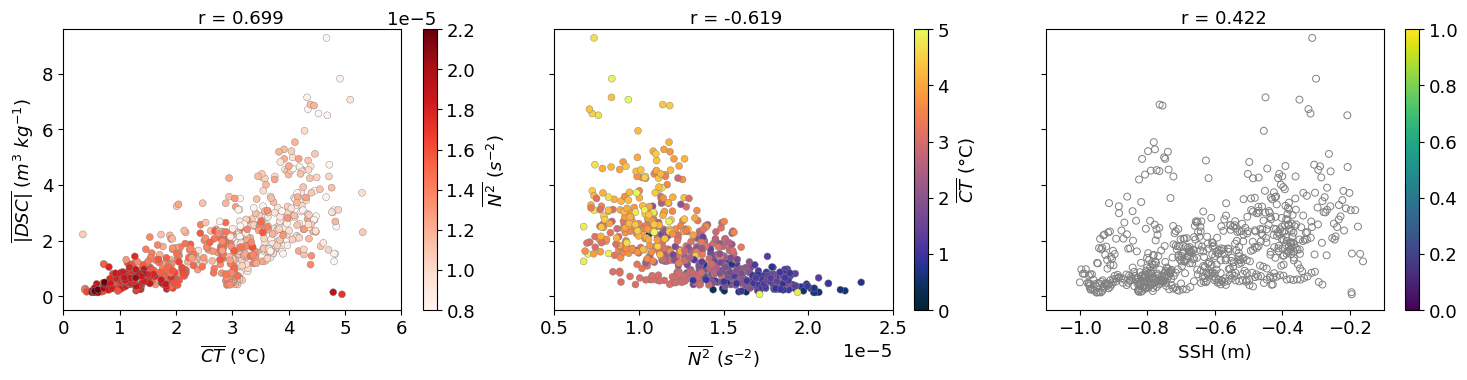

In [158]:
fig, ax = plt.subplots(1, 3, sharey = True, figsize = (15,4))

axs = ax.flatten()

x = avg_T
y = avg_dsc
c = avg_N2

im = axs[0].scatter(x, y, c = c, s= 25, cmap = 'Reds', vmin = 0.8e-5, vmax = 2.2e-5,
                 edgecolors = 'grey', linewidth = 0.3)

axs[0].set_ylim(-0.5, 9.6)
axs[0].set_xlim(0, 6)
axs[0].set_ylabel('$\overline{|DSC|}$ ($m^{3}$ $kg^{-1}$)')
axs[0].set_xlabel('$\overline{CT}$ (\N{DEGREE SIGN}C)')
plt.colorbar(im, ax = axs[0], label = '$\overline{N^{2}}$ $(s^{-2})$')

r, p = stats.pearsons(x, y, print_info = True)
axs[0].text(0.4, 1.02, f'r = {r:.3f}', transform = axs[0].transAxes)


x = avg_N2
y = avg_dsc
c = avg_T

im1 = axs[1].scatter(x, y, c = c, s = 25, cmap = cmocean.cm.thermal, vmin = 0, vmax = 5,
                                     edgecolors = 'grey', linewidth = 0.3)

axs[1].set_xlim(0.5e-5, 2.5e-5)
axs[1].set_xlabel('$\overline{N^{2}}$ $(s^{-2})$')
axs[1].set_ylabel('')
plt.colorbar(im1, ax = axs[1], label = '$\overline{CT}$ (\N{DEGREE SIGN}C)')

r, p = stats.pearsons(x, y, print_info = True)
axs[1].text(0.4, 1.02, f'r = {r:.3f}', transform = axs[1].transAxes)


x = adt_concat

im2 = axs[2].scatter(x, y, s = 25, facecolors = 'none', edgecolors = 'grey', linewidth = 0.7)
    
axs[2].set_xlim(-1.1, -0.1)
axs[2].set_ylabel('')
plt.colorbar(im2, ax = axs[2])
axs[2].set_xlabel('SSH (m)')

r, p = stats.pearsons(x, y, print_info = True)
axs[2].text(0.4, 1.02, f'r = {r:.3f}', transform = axs[2].transAxes)

plt.tight_layout()

# settings.save_figure(fig, my_path, 'Triaxus_DSC_scatter.png', dpi = 600, pad = 0.2)